In [ ]:
import os
import random
import json

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sentence_transformers import SentenceTransformer
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
)

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

# **Dataset load and split**

In [ ]:
SYNTH_PATH = "/content/synthetic_data_for_classification.jsonl"

df = pd.read_json(SYNTH_PATH, lines=True)

print("Synthetic dataset size:", df.shape)
df.head()


Synthetic dataset size: (1900, 5)


,model_name,anchor_text,text_a,text_b,text_a_is_closer
0,meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo,"A mysterious individual, known only by their a...","In the coastal city of Tidal Cove, a reclusive...","In the secluded hamlet of Ravenshire, a myster...",False
1,gpt-4o,A mysterious drifter arrives in the lawless fr...,"In a sprawling, rain-soaked city, a quiet mech...",A lone wanderer arrives in the turbulent minin...,False
2,OpenAI GPT4o Mini,"A team of paranormal investigators, led by sea...","In a bustling modern city, a group of amateur ...","A group of spectral researchers, led by experi...",False
3,OpenAI GPT 5 Chat,A prolonged drought devastates a rural farming...,A severe heatwave grips the remote farming set...,"In a remote coastal town, a series of mysterio...",True
4,meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo,The film revolves around a Marine who is sever...,The film follows Gunnery Sergeant Ryder Thomps...,"In a dystopian future, Captain Rachel Kim, a r...",True


In [ ]:
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["text_a_is_closer"]
)

len(train_df), len(test_df)


(1520, 380)

# **Data Visualization**

Loaded dev_df: (200, 4)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


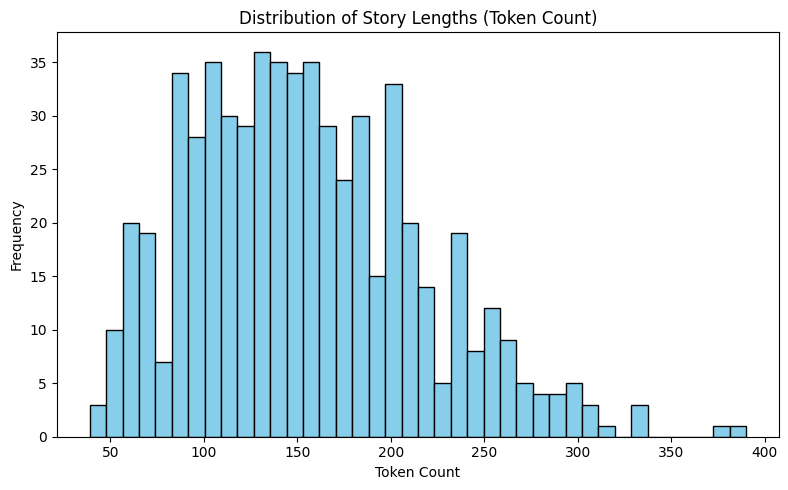

/tmp/ipython-input-1568178754.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["text_a_is_closer"], palette="Set2")


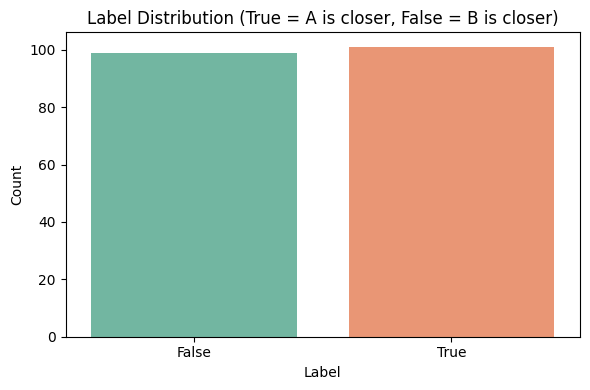

/tmp/ipython-input-1568178754.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["label"], palette="pastel")


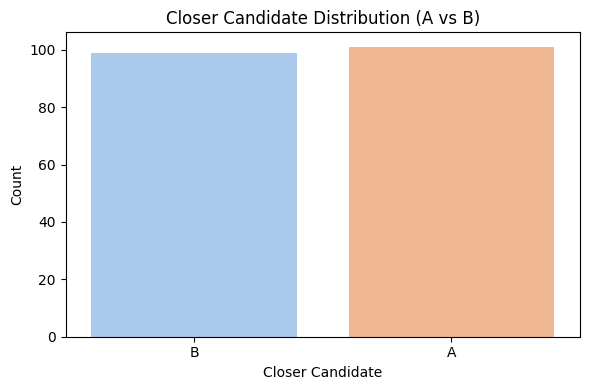

==== Story Length Summary ====
count    600.000000
mean     154.358333
std       61.275507
min       39.000000
25%      108.000000
50%      147.500000
75%      194.250000
max      390.000000
dtype: float64


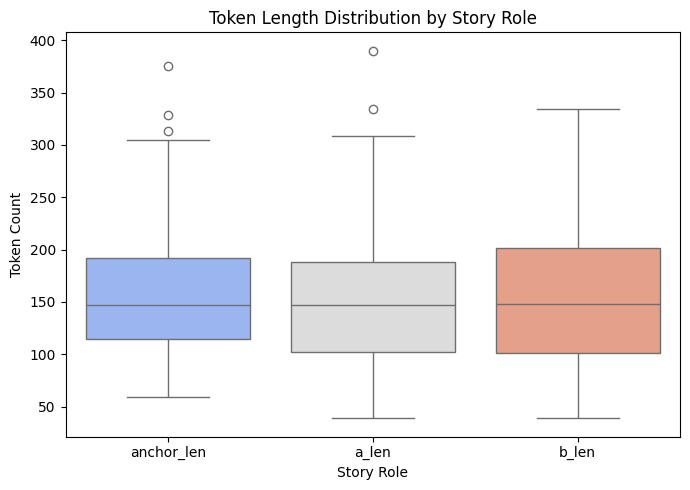

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer


DEV_PATH = "/content/dev_track_a.jsonl"

dev_df = pd.read_json(DEV_PATH, lines=True)
dev_df = dev_df.dropna(subset=["anchor_text", "text_a", "text_b"])  # remove NaN rows

print("Loaded dev_df:", dev_df.shape)

df = dev_df.copy()

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def count_tokens(text):
    if pd.isna(text):
        return 0
    return len(tokenizer.encode(text, add_special_tokens=False))


df["anchor_len"] = df["anchor_text"].apply(count_tokens)
df["a_len"]      = df["text_a"].apply(count_tokens)
df["b_len"]      = df["text_b"].apply(count_tokens)


lengths = pd.concat([df["anchor_len"], df["a_len"], df["b_len"]], ignore_index=True)

plt.figure(figsize=(8, 5))
plt.hist(lengths, bins=40, color="skyblue", edgecolor="black")
plt.title("Distribution of Story Lengths (Token Count)")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


plt.figure(figsize=(6,4))
sns.countplot(x=df["text_a_is_closer"], palette="Set2")
plt.title("Label Distribution (True = A is closer, False = B is closer)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

df["label"] = df["text_a_is_closer"].map({True: "A", False: "B"})

plt.figure(figsize=(6,4))
sns.countplot(x=df["label"], palette="pastel")
plt.title("Closer Candidate Distribution (A vs B)")
plt.xlabel("Closer Candidate")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


print("==== Story Length Summary ====")
print(lengths.describe())

plt.figure(figsize=(7,5))
sns.boxplot(data=df[["anchor_len", "a_len", "b_len"]], palette="coolwarm")
plt.title("Token Length Distribution by Story Role")
plt.xlabel("Story Role")
plt.ylabel("Token Count")
plt.tight_layout()
plt.show()


# **SBERT + MLP Classifier**

In [ ]:
sbert_model = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2", device=device)

def embed_batch(texts):
    return sbert_model.encode(
        list(texts),
        batch_size=64,
        convert_to_numpy=True,
        show_progress_bar=True
    )

train_anchor = embed_batch(train_df["anchor_text"])
train_a      = embed_batch(train_df["text_a"])
train_b      = embed_batch(train_df["text_b"])

test_anchor = embed_batch(test_df["anchor_text"])
test_a      = embed_batch(test_df["text_a"])
test_b      = embed_batch(test_df["text_b"])


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
X_train = np.concatenate([train_anchor, train_a, train_b], axis=1)
X_test  = np.concatenate([test_anchor,  test_a,  test_b],  axis=1)

y_train = train_df["text_a_is_closer"].astype(int).values
y_test  = test_df["text_a_is_closer"].astype(int).values

X_train.shape, X_test.shape


((1520, 1152), (380, 1152))

MLP classifier

In [ ]:
class SBERTMLP(nn.Module):
    def __init__(self, input_dim, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)


Training

In [ ]:
input_dim = X_train.shape[1]
model_mlp = SBERTMLP(input_dim).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model_mlp.parameters(), lr=1e-3)

class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(NumpyDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader  = DataLoader(NumpyDataset(X_test, y_test),  batch_size=64, shuffle=False)


In [ ]:
def train_mlp(model, loader, epochs=5):
    model.train()
    for ep in range(1, epochs+1):
        total = 0
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(Xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            total += loss.item()*len(Xb)
        print(f"Epoch {ep} - Loss: {total/len(loader.dataset):.4f}")

train_mlp(model_mlp, train_loader, epochs=5)


Epoch 1 - Loss: 0.6333
Epoch 2 - Loss: 0.4141
Epoch 3 - Loss: 0.2473
Epoch 4 - Loss: 0.1673
Epoch 5 - Loss: 0.1295


Evaluate MLP

In [ ]:
def eval_mlp(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for Xb, yb in loader:
            logits = model(Xb.to(device)).cpu().numpy()
            preds.append((logits > 0).astype(int))
            labels.append(yb.numpy())
    preds = np.concatenate(preds)
    labels = np.concatenate(labels)
    print("Accuracy:", accuracy_score(labels, preds))
    print(classification_report(labels, preds))
    return accuracy_score(labels, preds)

eval_mlp(model_mlp, test_loader)


Accuracy: 0.9394736842105263
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94       191
         1.0       0.97      0.90      0.94       189

    accuracy                           0.94       380
   macro avg       0.94      0.94      0.94       380
weighted avg       0.94      0.94      0.94       380



0.9394736842105263

# **DeBERTa-v3 CROSS-ENCODER**

In [ ]:
def triple_to_seq(row):
    return (
        f"Anchor: {row['anchor_text']}\n\n"
        f"Story A: {row['text_a']}\n\n"
        f"Story B: {row['text_b']}"
    )

train_texts = train_df.apply(triple_to_seq, axis=1).tolist()
test_texts  = test_df.apply(triple_to_seq, axis=1).tolist()

train_labels = train_df["text_a_is_closer"].astype(int).tolist()
test_labels  = test_df["text_a_is_closer"].astype(int).tolist()


In [ ]:
class TripleDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):
        t = self.tokenizer(
            self.texts[i],
            padding="max_length",
            truncation=True,
            max_length=self.max_len
        )
        item = {k: torch.tensor(v) for k,v in t.items()}
        item["labels"] = torch.tensor(self.labels[i], dtype=torch.long)
        return item


Load DeBERTa Model

In [ ]:
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
deberta = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
deberta.to(device)

train_dataset = TripleDataset(train_texts, train_labels, tokenizer)
test_dataset  = TripleDataset(test_texts,  test_labels,  tokenizer)


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train & Evaluate DeBERTa

In [ ]:
from torch.optim import AdamW
from tqdm.auto import tqdm

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Optimizer (mimic Trainer defaults)
optimizer = AdamW(deberta.parameters(), lr=2e-5, weight_decay=0.01)

num_epochs = 3

for epoch in range(num_epochs):
    deberta.train()
    total_loss = 0.0
    total_examples = 0
    correct = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch in pbar:
        # Move to device
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch.pop("labels")

        optimizer.zero_grad()

        outputs = deberta(**batch, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        batch_size = labels.size(0)
        total_loss += loss.item() * batch_size
        total_examples += batch_size

        preds = torch.argmax(logits, dim=-1)
        correct += (preds == labels).sum().item()

        pbar.set_postfix({
            "loss": f"{total_loss / total_examples:.4f}",
            "acc": f"{correct / total_examples:.4f}"
        })

    # Simple validation at end of epoch
    deberta.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch.pop("labels")

            outputs = deberta(**batch)
            preds = torch.argmax(outputs.logits, dim=-1)

            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total if val_total > 0 else 0.0
    print(f"\nEpoch {epoch+1} validation accuracy: {val_acc:.4f}\n")


Epoch 1/3:   0%|          | 0/380 [00:00<?, ?it/s]


Epoch 1 validation accuracy: 0.9684



Epoch 2/3:   0%|          | 0/380 [00:00<?, ?it/s]


Epoch 2 validation accuracy: 0.9974



Epoch 3/3:   0%|          | 0/380 [00:00<?, ?it/s]


Epoch 3 validation accuracy: 0.9974



In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"


# **Evaluate on Development set**

load dev dataset

In [ ]:
DEV_PATH = "dev_track_a.jsonl"
dev_df = pd.read_json(DEV_PATH, lines=True)

print(dev_df.shape)
dev_df.head()


(200, 4)


,anchor_text,text_a,text_b,text_a_is_closer
0,The book follows an international organization...,The old grandmother Tina arrives in town to at...,The nano-plague that poisoned Earth's water su...,False
1,"Glenn Tyler (Elvis Presley), a childish 25-yea...","Bill Babbitt supported the death penalty, unti...",A white-collar suburban father Kyle (Fran Kran...,True
2,Signaller Charles Plumpick (Bates) is a kilt-w...,"Sid, Russ and Jerry are three wannabe criminal...",Brendan Byers III is a rich playboy who enlist...,False
3,Barbara is married to the distinguished profes...,Eddie Quinn's unruly wife Maureen drinks and s...,Jerome Littlefield is an orderly at a hospital...,False
4,A wealthy widower locks up his two grown-up ch...,Barbara is married to the distinguished profes...,Stefano (Lino Capolicchio) arrives in a villag...,False


evaluate SBERT + MLP classifier

In [ ]:
dev_anchor = embed_batch(dev_df["anchor_text"])
dev_a      = embed_batch(dev_df["text_a"])
dev_b      = embed_batch(dev_df["text_b"])

X_dev = np.concatenate([dev_anchor, dev_a, dev_b], axis=1)
y_dev = dev_df["text_a_is_closer"].astype(int).values

dev_loader = DataLoader(NumpyDataset(X_dev, y_dev), batch_size=64, shuffle=False)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
print("SBERT+MLP accuracy on DEV set:")
eval_mlp(model_mlp, dev_loader)


SBERT+MLP accuracy on DEV set:
Accuracy: 0.5
              precision    recall  f1-score   support

         0.0       0.49      0.43      0.46        99
         1.0       0.50      0.56      0.53       101

    accuracy                           0.50       200
   macro avg       0.50      0.50      0.50       200
weighted avg       0.50      0.50      0.50       200



0.5

evaluate DeBERTa cross-encoder on dev set

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import torch

def predict_deberta(model, dataset):
    model.eval()
    preds = []
    labels = []
    loader = DataLoader(dataset, batch_size=8)

    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        with torch.no_grad():
            logits = model(**batch).logits
        batch_preds = torch.argmax(logits, dim=-1).cpu().numpy()

        preds.extend(batch_preds)

    return np.array(preds)


In [ ]:
def triple_to_seq(anchor, a, b):
    return f"[ANCHOR] {anchor} [CAND_A] {a} [CAND_B] {b}"


In [ ]:
# Build dev set for final evaluation (SemEval official dev set)
dev_texts  = [
    triple_to_seq(row["anchor_text"], row["text_a"], row["text_b"])
    for _, row in dev_df.iterrows()
]

dev_labels = dev_df["text_a_is_closer"].astype(int).tolist()

dev_dataset = TripleDataset(dev_texts, dev_labels, tokenizer)


In [ ]:
deberta_preds = predict_deberta(deberta, dev_dataset)
deberta_labels = np.array(dev_labels)


In [ ]:
print("DeBERTa Accuracy:", accuracy_score(deberta_labels, deberta_preds))
print(classification_report(deberta_labels, deberta_preds, digits=4))


DeBERTa Accuracy: 0.495
              precision    recall  f1-score   support

           0     0.4950    1.0000    0.6622        99
           1     0.0000    0.0000    0.0000       101

    accuracy                         0.4950       200
   macro avg     0.2475    0.5000    0.3311       200
weighted avg     0.2450    0.4950    0.3278       200



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **PLOTS for report**

In [ ]:
import numpy as np
import pandas as pd

# Compute token lengths for anchor, A, B
def count_tokens(text):
    return len(tokenizer.encode(text, add_special_tokens=False))

dev_df["anchor_len"] = dev_df["anchor_text"].apply(count_tokens)
dev_df["a_len"]      = dev_df["text_a"].apply(count_tokens)
dev_df["b_len"]      = dev_df["text_b"].apply(count_tokens)

# Combined story length feature
dev_df["avg_len"] = (dev_df["anchor_len"] + dev_df["a_len"] + dev_df["b_len"]) / 3

# Add prediction + gold labels
dev_df["gold"] = dev_labels
dev_df["pred"] = deberta_preds

# correctness flag
dev_df["correct"] = (dev_df["gold"] == dev_df["pred"]).astype(int)


Plot 1 — Accuracy vs Story Length

/tmp/ipython-input-1306897331.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_len = dev_df.groupby("len_bin")["correct"].mean().reset_index()


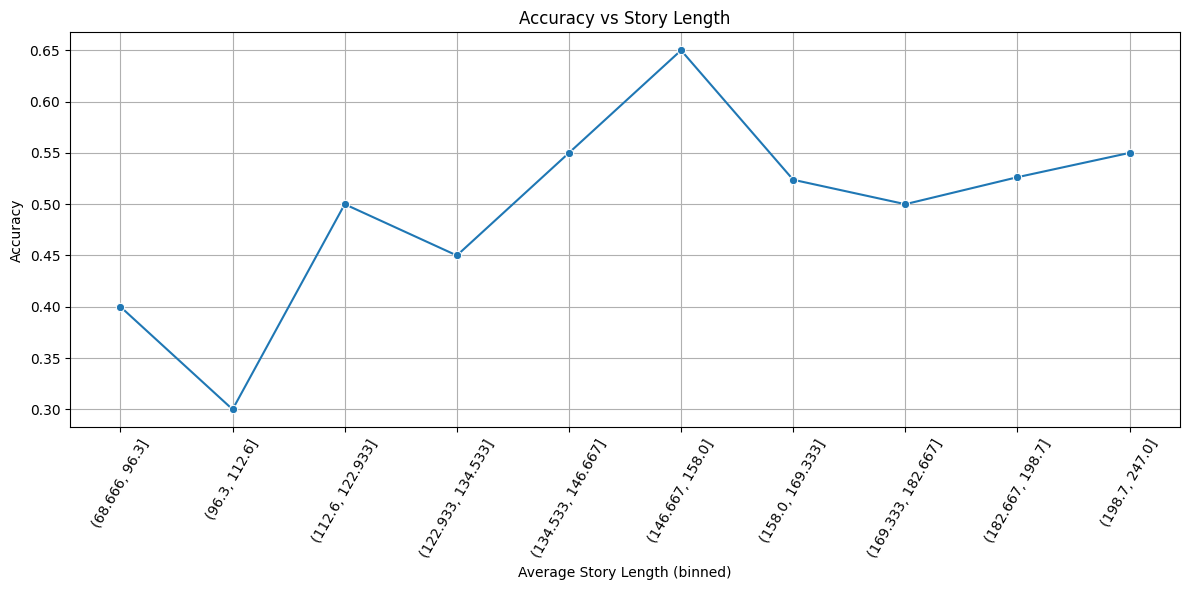

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bin story length into quantiles
dev_df["len_bin"] = pd.qcut(dev_df["avg_len"], q=10, duplicates="drop")

# Accuracy by bin
acc_by_len = dev_df.groupby("len_bin")["correct"].mean().reset_index()

# Convert intervals to readable strings for plotting
acc_by_len["len_bin"] = acc_by_len["len_bin"].astype(str)

plt.figure(figsize=(12,6))
sns.lineplot(data=acc_by_len, x="len_bin", y="correct", marker="o")
plt.xticks(rotation=60)
plt.ylabel("Accuracy")
plt.xlabel("Average Story Length (binned)")
plt.title("Accuracy vs Story Length")
plt.grid(True)
plt.tight_layout()
plt.show()
